In [1]:
import numpy as np 
import pandas as pd 
import os
import sys 
import torch 
from matplotlib import pyplot as plt 
from glob import glob 
import cv2 
import open3d as o3d   
import gc
gc.collect()

sys.path.append("/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/src")
from utils.load_tof_images import create_from_zip_absolute  as load_assignment_data
from data_loader.data_loader_assignment import CreateAssignemntDataset
from utils.data_transforms import pre_process

path = "../Data/Assignment_data/360_scan/"
rgb_files = glob(path+"/*/rgb/*")
print("Total RGB images ",len(rgb_files))


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total RGB images  255


../Data/Assignment_data/360_scan/data6/rgb/16
240 180


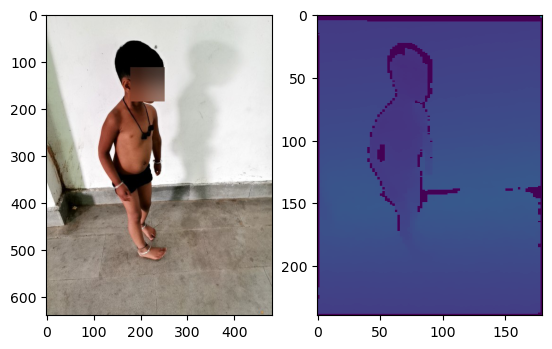

In [2]:
rgb_fpath = rgb_files[np.random.randint(0,255)]
print(rgb_fpath)
depth_fpath = rgb_fpath.replace('rgb','depth')
calib_fpath = os.path.dirname(rgb_fpath).replace('rgb','calibration/0')

data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)
rgb_image = data[8]
depth_map = data[3]

plt.subplot(1,2,1)
plt.imshow(rgb_image)
plt.subplot(1,2,2)
plt.imshow(depth_map)

In [3]:
# print properties:
print(f"Image resolution: {depth_map.shape}")
print(f"Data type: {depth_map.dtype}")
print(f"Min value: {np.min(depth_map)}")
print(f"Max value: {np.max(depth_map)}")

Image resolution: (240, 180)
Data type: float64
Min value: 0.0
Max value: 3.076


### Setting the Depth camera calibration for Asssignment dataset 

- The calibration matrix M is a 3×3 matrix:

                | fx 0   cx |
                | 0  fy  cy |
                | 0  0   1  |

Where fx, fy and cx, cy are the focal length and the optical centers

- Point cloud computing
Computing point cloud here means transforming the depth pixel from the depth image 2D coordinate system to the depth camera 3D coordinate system (x, y and z). The 3D coordinates are computed using the following formulas, where depth(i, j) is the depth value at the row i and column j:
            
            | z = depth(i,j)       |
            | x = ( (j-cx) x z)/fx |
            | y = ( (i-cy) x z)/fy |
            
[Link](https://betterprogramming.pub/point-cloud-computing-from-rgb-d-images-918414d57e80) to info

In [4]:
# Depth camera parameters:
# Depth camera parameters:
FX_DEPTH = 0.7811297
FY_DEPTH = 1.5166936
CX_DEPTH = 0.50329405
CY_DEPTH = 0.5187362

In [5]:
visualize = False
if visualize:
    # get depth resolution:
    height, width = depth_map.shape
    length = height * width
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_map.reshape(length)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                    (jj - CY_DEPTH) * z / FY_DEPTH,
                    z]).reshape((length, 3))

    pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
    # Visualize:
    o3d.visualization.draw_geometries([pcd_o3d])

### Obtain Depth Image from the Trained model 

In [6]:
import torch as th 
from PIL import Image
from depth_model.model import PTModel

print(th.cuda.is_available())

device = 'cuda' if th.cuda.is_available() else 'cpu'
fine_tune_model_checkpoint = "/mnt/e/Personal/Samarth/repository/RGB_to_3D_conversion/model/child_depth_model.ckpt"
fine_tune_depth_model = PTModel().float().to(device)

fine_tune_depth_model.load_state_dict(torch.load(fine_tune_model_checkpoint))
gc.collect()

True


/home/samartht/anaconda3/envs/ptorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samartht/anaconda3/envs/ptorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


14

In [8]:
def tensor_to_numpy_image(image,rgb=True):
    image = image.permute(1,0,2,3).squeeze(axis=0).cpu().detach().numpy()
    if rgb:
        image = image.squeeze(axis=1)
        return np.array(image.transpose(1, 2, 0)*255, dtype=np.uint8) 
    else:
        return image.squeeze(axis=0)
    

def get_predictions(test_image , model,depth_scale=0.01):
    model.eval()
    test_image = cv2.resize(test_image ,(480,640),interpolation=cv2.INTER_LINEAR)
    test_image = torch.from_numpy(np.transpose(test_image, (2, 0, 1)))
    test_image = test_image.float().to(device)
    test_image = torch.unsqueeze(test_image,dim=0) # torch.Size([1, 3, 480, 640])
    
    y_pred = model(test_image)
    y_pred = tensor_to_numpy_image(y_pred,rgb=False)
    y_pred = y_pred/ np.max(y_pred) 
    y_pred = np.where(y_pred<0 , 0 ,y_pred)
    return np.asarray(y_pred,dtype=np.float32)


data = load_assignment_data(rgb_fpath=rgb_fpath,depthmap_fpath=depth_fpath,calibration_fpath=calib_fpath)
rgb_image = data[8]
depth_map = data[3]
depth_scale = data[4]
predicted_image = get_predictions(test_image=rgb_image,model=fine_tune_depth_model,depth_scale=depth_scale)

In [9]:
# print properties:
print(f"Image resolution: {predicted_image.shape}")
print(f"Data type: {predicted_image.dtype}")
print(f"Min value: {np.min(predicted_image)}")
print(f"Max value: {np.max(predicted_image)}")
# predicted_image = DepthNorm(predicted_image,100)
torch.cuda.empty_cache()
gc.collect()

Image resolution: (320, 240)
Data type: float32
Min value: 0.0
Max value: 1.0


541

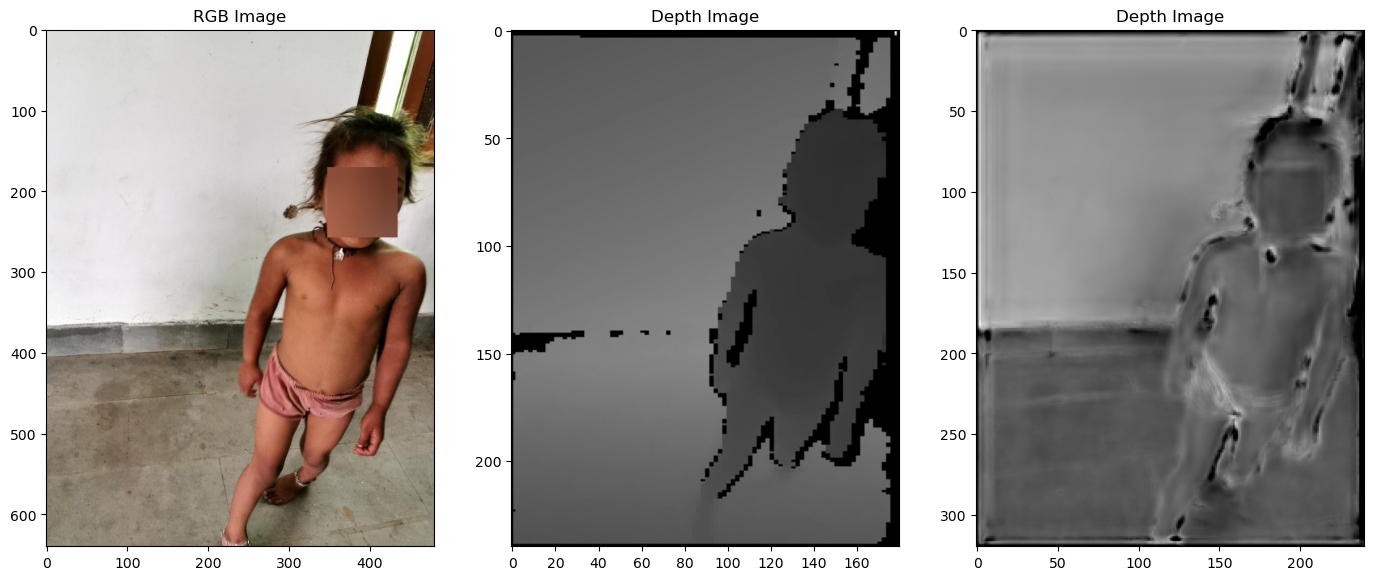

In [11]:
plt.figure(figsize=(17,19))
plt.subplot(1,3,1)
plt.title("RGB Image")
plt.imshow(rgb_image)

plt.subplot(1,3,2)
plt.title("Depth Image")
plt.imshow(data[3],cmap='gray')

plt.subplot(1,3,3)
plt.title("Depth Image")
plt.imshow(predicted_image,cmap='gray')

# depth_instensity = np.array(255*predicted_image/0x0fff,# / 0x0fff,
#                             dtype=np.int8)
# # iio.imwrite('grayscale.png', depth_instensity)

In [4]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
checkpoint = "vinvino02/glpn-nyu"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForDepthEstimation.from_pretrained(checkpoint)

pixel_values = image_processor(data[8], return_tensors="pt").pixel_values
with torch.no_grad():
    outputs = model(pixel_values)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=(240,320),
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.numpy()
formatted = (output/ np.max(output)).astype(np.float32)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
data[3].shape

(240, 180)

In [16]:
def parse_depth_data(data, width, height, depth_scale) -> np.ndarray:
    output = np.zeros((width, height))
    for x in range(width):
        for y in range(height):
            output[x, y] = parse_depth(data, x, y, width, height, depth_scale)
    return output


def parse_depth(data: bytes, tx: int, ty: int, width, height, depth_scale) -> float:
    """Get depth of the point in meters"""
    if tx < 1 or ty < 1 or tx >= width or ty >= height:
        return 0.
    index = height - int(ty) - 1
    depth = data[(index * width + int(tx)) * 3 + 0] << 8
    depth += data[(index * width + int(tx)) * 3 + 1]
    depth *= depth_scale
    return depth

resize = cv2.resize(formatted,(240,180))
print(resize.shape)
success, encoded_image = cv2.imencode('.png', resize)

parse_depth_data (encoded_image.tobytes(),240,180,0.01)

(180, 240)
178 42721


IndexError: index out of range

In [15]:
len(encoded_image.tobytes())

3932

In [15]:
# get depth resolution:
height, width = predicted_image.shape
length = height * width

# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)

# reshape depth image
z = predicted_image.reshape(length)

# compute pcd:
pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))

In [16]:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

###  Points with Minimum  and max values at each axis 

In [17]:
x_max = max(pcd_o3d.points,key=lambda x: x[0])
y_max = max(pcd_o3d.points,key=lambda x: x[1])
z_max = max(pcd_o3d.points,key=lambda x: x[2])

x_min = min(pcd_o3d.points,key=lambda x: x[0])
y_min = min(pcd_o3d.points,key=lambda x: x[1])
z_min = min(pcd_o3d.points,key=lambda x: x[2])

print(x_max,y_max,z_max)
print(x_min,y_min,z_min)


[207.62081926  17.77582036   0.68286753] [  4.43122216 155.54579008   0.76975441] [173.46249406 106.46927224   1.        ]
[-0.24542968 49.84827055  0.38091531] [160.44345269  -0.24424455   0.7141282 ] [-0. -0.  0.]
